In [16]:
import os
import pandas
import copy
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


In [17]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

<br/><br/><br/>
*Danny Weitekamp, Learning_Curves, GitHub repository:*
- [Learning_Curves](https://github.com/DannyWeitekamp/Learning_Curves)

In [18]:
def generate_step_slices(x):
    outcomes = x['Outcome']
    last_correct = 0
    for row in range(x.shape[0]):
        if((outcomes[row]) == "CORRECT"):
            yield x[last_correct:row+1]
            last_correct = row+1

            
def generate_step_dicts(student_table, KC='KC (Field)',only_first_error=True):
    opportunity_counts = {}
    

    for step_slice in generate_step_slices(student_table):
        step_name = step_slice[KC].iloc[-1]
 
        if(not isinstance(step_name,str) or step_name == ""):
            continue
        
        d = {}
        for _,table_row in step_slice.iterrows():           
  
            if(str(table_row['Outcome']).strip().upper() == "INCORRECT"):
        
                d["general error"] = True
        
                if(table_row["error_type"] == "incorrect"):
                    d["incorrect"] = True

                elif(table_row['error_type'] == "misapplied"):
                    d["misapplied"] = True
                     
                elif(table_row['error_type'] == "out of graph"):  
                    d["out of graph"] = True
                    
                elif(table_row['error_type'] == "repeat"):  
                    d["repeat"] = True
                    
                elif(table_row['error_type'] == "when error"):  
                    d["when error"] = True    
                    
                elif(table_row['error_type'] == "where error"):  
                    d["where error"] = True 
                    
                elif(table_row['error_type'] == "wild error"):  
                    d["wild error"] = True 
            
                 
                    
            elif(str(table_row['Outcome']).strip().upper() == "HINT"):
                d["hint"] = True
                
            if(only_first_error):
                break
        d['KC'] = step_name 
    
        
        opportunity_counts[step_name] = opportunity_counts.get(step_name,0) + 1
        d['Opportunity'] = opportunity_counts[step_name]
        
        yield d    
    
    
def increment_at_index(l,i,amount=0):
    if(i < len(l)):
        l[i] += amount
    elif(i == len(l)):
        l.extend([amount])
    else:
        raise ValueError("Nope", len(l), i)
        
                
def get_learning_curves(student_tables, KC='KC (Field)',only_first_error=True):
    kc_dict = {}
    kc_template = {"Counts": [], "Errors": [], "Incorrect": [], "Misapplied": [], "Out of graph" : [], "Repeat" :[], "When error":[], "Where error": [], "Wild error": [], "Hint error" : []}
    
    
    
    for st in student_tables:
        for sd in generate_step_dicts(st, KC=KC,only_first_error=only_first_error):
            kc_name = sd.get('KC',None)
            kc_data = kc_dict.get(kc_name, copy.deepcopy(kc_template))
            
            
            
            increment_at_index(kc_data["Counts"], sd["Opportunity"] -1, 1)

            inc, mis, out, rep, when, where, wild, h = sd.get('incorrect',False), sd.get('misapplied',False),sd.get('out of graph',False), sd.get('repeat',False), sd.get('when error',False), sd.get('where error',False), sd.get('wild error',False), sd.get('hint',False)  
            
            gen = sd.get('general error', False)
            
            
            op = sd["Opportunity"]
            indx = op-1
   
            increment_at_index(kc_data["Errors"], indx, 1 if inc or mis or out or rep or when or where or wild or h or gen else 0) 
            increment_at_index(kc_data["Incorrect"], indx, 1 if inc else 0) 
            increment_at_index(kc_data["Misapplied"], indx, 1 if mis else 0)
            increment_at_index(kc_data["Out of graph"], indx, 1 if out else 0)
            increment_at_index(kc_data["Repeat"], indx, 1 if rep else 0)
            increment_at_index(kc_data["When error"], indx, 1 if when else 0)
            increment_at_index(kc_data["Where error"], indx, 1 if where else 0)
            increment_at_index(kc_data["Wild error"], indx, 1 if wild else 0)
            increment_at_index(kc_data["Hint error"], indx, 1 if h else 0)
            
            kc_dict[kc_name] = kc_data
                    
    return kc_dict

def gen_student_tables(df):
    student_tables = []
    for x in df['Anon Student Id'].unique():
        student_tables.append(df[df['Anon Student Id'] == x])
    return student_tables

def transaction_file_to_df(path):
    df = pandas.read_csv(path, sep='\t',lineterminator='\n', skip_blank_lines=True).replace({r'\r': ''}, regex=True)
    df = df.rename(index=str, columns={a:a.rstrip() for a in df.keys()})
    return df
            
def curves_from_transaction_file(df, KC='KC (Field)',only_first_error=True):

    df = transaction_file_to_df(df)          
    student_tables = gen_student_tables(df)
    learning_curves_by_kc = get_learning_curves(student_tables, KC=KC,only_first_error=only_first_error)
    return learning_curves_by_kc
    

                
 




In [19]:

def graph_kc(name, kc, shrink):
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    
    counts = np.array(kc['Counts'], dtype=np.float)
    error = np.array(kc['Errors'], dtype=np.float)/counts
    
    inc_error = np.array(kc['Incorrect Errors'], dtype=np.float)/counts
    mis_error = np.array(kc['Misapplied Errors'], dtype=np.float)/counts
    out_error = np.array(kc['Out of graph Errors'], dtype=np.float)/counts
    rep_error = np.array(kc['Repeat Errors'], dtype=np.float)/counts
    when_error = np.array(kc['When Errors'], dtype=np.float)/counts
    where_error = np.array(kc['Where Errors'], dtype=np.float)/counts  
    wild_error = np.array(kc['Wild Errors'], dtype=np.float)/counts
    hint_error = np.array(kc['Hint Errors'], dtype=np.float)/counts
    
    
    fig = plt.figure() 
    plt.figure(figsize=(15,10))
    
    
    ax = plt.subplot(111)    
    
    x = np.arange(len(counts))
    
    
    ax.plot(x, inc_error, # marker="d", 
            label='incorrect error', color=colors['gold'])
    ax.plot(x, mis_error, # marker="s",
            label='misapplied error', color=colors['green'])
    ax.plot(x, out_error, # marker="1" , 
            label='out of graph error', color=colors['dodgerblue'])
    ax.plot(x, rep_error, # marker = 'p',
            label='repeat error', color=colors['gray'])
    ax.plot(x, when_error, # marker = '*',
            label='when error', color=colors['magenta'])
    ax.plot(x, where_error, # marker = 'D',
            label='where error', color=colors['orange'])
    ax.plot(x, wild_error, # marker = 'x', 
            label='wild error', color=colors['lightblue'])
    
    ax.plot(x, hint_error, # marker = 'x', 
            label='hint error', color=colors['blueviolet'])
    
    
    if shrink: ax.set_ylim([-0.01,0.2])
    
    else: 
        ax.set_ylim([-0.01,1.025])
        ax.plot(x, error,  # marker="o",
            label='total error', color=colors['firebrick'])
 
    ax.legend()
    plt.title('KC: %s' % name)
    plt.ylabel('Error')
    #plt.show()

    
def add_counts(a,b):
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c


def aggregate_curves(d, selection=None):
    if(selection == None): selection = d.keys();
    print(selection)
    agg_curve = {}
    for (kc_name, kc) in d.items() :     
        
        if(kc_name in selection):

            counts = np.array(kc['Counts'], dtype=np.float)
            errors = np.array(kc['Errors'], dtype=np.float)
            inc_errors = np.array(kc['Incorrect'], dtype=np.float)
            mis_errors = np.array(kc['Misapplied'], dtype=np.float)
            out_errors = np.array(kc['Out of graph'], dtype=np.float)
            rep_errors = np.array(kc['Repeat'], dtype=np.float)
            when_errors = np.array(kc['When error'], dtype=np.float)
            where_errors = np.array(kc['Where error'], dtype=np.float)
            wild_errors = np.array(kc['Wild error'], dtype=np.float)
            
            hint_errors = np.array(kc['Hint error'], dtype=np.float)
            
            
            
            
            
            agg_curve['Counts'] = add_counts(agg_curve.get('Counts',np.zeros(0)), counts)
            agg_curve['Errors'] = add_counts(agg_curve.get('Errors',np.zeros(0)), errors)
            agg_curve['Incorrect Errors'] = add_counts(agg_curve.get('Incorrect Errors',np.zeros(0)), inc_errors)
            agg_curve['Misapplied Errors'] = add_counts(agg_curve.get('Misapplied Errors',np.zeros(0)), mis_errors)
            agg_curve['Out of graph Errors'] = add_counts(agg_curve.get('Out of graph Errors',np.zeros(0)), out_errors)
            agg_curve['Repeat Errors'] = add_counts(agg_curve.get('Repeat Errors',np.zeros(0)), rep_errors)
            agg_curve['When Errors'] = add_counts(agg_curve.get('When Errors',np.zeros(0)), when_errors)
            agg_curve['Where Errors'] = add_counts(agg_curve.get('Where Errors',np.zeros(0)), where_errors)
            agg_curve['Wild Errors'] = add_counts(agg_curve.get('Wild Errors',np.zeros(0)), wild_errors)
            
            agg_curve['Hint Errors'] = add_counts(agg_curve.get('Hint Errors',np.zeros(0)), hint_errors)
            
            

            
    return agg_curve
            

In [20]:
'''
plot_learning_curves: takes in a transaction file and plot errors split by error types with respect to number of opportunities
Input:
    -transaction_path: a path for the transaction log
    -title: title of the graph
    -KC: name of the KC model 
    -only_first_error: whether only to consider the first error made. Default set to True
    -selection: names of KC to aggregate in the plot. Default set to include all KC.
    -shrink: if set to True, plot will have range of y-axis shrinked 
Output: a plot showing the learning curves split by error types
'''

def plot_learning_curves(transaction_path, title, KC='KC (Field)', only_first_error = True, selection = None, shrink = False):
    curves = curves_from_transaction_file(transaction_path, KC = KC, only_first_error = only_first_error)
    graph_kc(title, aggregate_curves(curves, selection), shrink)



In [21]:
'''
error_by_clusters: plot a graph showing errors across clusters aggregated across all KCs
Input:
    -title: title of the graph
    -c1_path: a path for the transaction log of first cluster 
    -c2_path: a path for the transaction log of second cluster 
    -c3_path: a path for the transaction log of third cluster 
    -error: types of errors to compare acdross clusters
Output: plot a graph showing errors across clusters aggregated across all KCs

'''

def error_by_clusters(title, c1_path, c2_path, c3_path, error = 'Errors'):
    
    c1 = aggregate_curves(curves_from_transaction_file(c1_path))
    c2 = aggregate_curves(curves_from_transaction_file(c2_path))
    c3 = aggregate_curves(curves_from_transaction_file(c3_path))

    
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    counts1, counts2, counts3 = np.array(c1['Counts'], dtype=np.float), np.array(c2['Counts'], dtype=np.float), np.array(c3['Counts'], dtype=np.float)
    
    error1 = np.array(c1[error], dtype=np.float)/counts1
    error2 = np.array(c2[error], dtype=np.float)/counts2
    error3 = np.array(c3[error], dtype=np.float)/counts3
    
    
    fig = plt.figure()
    
    plt.figure(figsize=(15,10))
    
    
    ax = plt.subplot(111)    
    
    ax.plot(np.arange(len(counts1)), error1,  # marker="o",
            label= 's1', color=colors['firebrick'])
            
    ax.plot(np.arange(len(counts2)), error2,  # marker="o",
            label= 's2', color=colors['orange'])
            
    ax.plot(np.arange(len(counts3)), error3,  # marker="o",
            label= 's3', color=colors['lightblue'])        
            
    
    ax.set_ylim([-0.01,1.025])

 #  ax.set_ylim([-0.01,0.65])

    ax.legend()
    plt.title('KC: %s' % title)
    plt.ylabel('Error')
    #plt.show()

In [22]:

'''
residuals_kc: shows a residual plot by substracting iso curves from student curves
Input:
    -name: title of the graph
    -stu_path: path for the student transaction log
    -iso_path: path for the iso transaction log
Output: a graph showing the residuals of the curves generated from the two log file

'''


def residuals_kc(name, stu_path, iso_path):
    
    stu = aggregate_curves(curves_from_transaction_file(stu_path))
    iso = aggregate_curves(curves_from_transaction_file(iso_path))

    
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
  #  print("kc:", kc)
    
    counts_s = np.array(stu['Counts'], dtype=np.float)
    error_s = np.array(stu['Errors'], dtype=np.float)/counts_s
    
    inc_error_s = np.array(stu['Incorrect Errors'], dtype=np.float)/counts_s
    mis_error_s = np.array(stu['Misapplied Errors'], dtype=np.float)/counts_s
    out_error_s = np.array(stu['Out of graph Errors'], dtype=np.float)/counts_s
    rep_error_s = np.array(stu['Repeat Errors'], dtype=np.float)/counts_s
    when_error_s = np.array(stu['When Errors'], dtype=np.float)/counts_s
    where_error_s = np.array(stu['Where Errors'], dtype=np.float)/counts_s  
    wild_error_s = np.array(stu['Wild Errors'], dtype=np.float)/counts_s
    hint_error_s = np.array(stu['Hint Errors'], dtype=np.float)/counts_s
    
    
    
    counts_i = np.array(iso['Counts'], dtype=np.float)
    error_i = np.array(iso['Errors'], dtype=np.float)/counts_i
    
    inc_error_i = np.array(iso['Incorrect Errors'], dtype=np.float)/counts_i
    mis_error_i = np.array(iso['Misapplied Errors'], dtype=np.float)/counts_i
    out_error_i = np.array(iso['Out of graph Errors'], dtype=np.float)/counts_i
    rep_error_i = np.array(iso['Repeat Errors'], dtype=np.float)/counts_i
    when_error_i = np.array(iso['When Errors'], dtype=np.float)/counts_i
    where_error_i = np.array(iso['Where Errors'], dtype=np.float)/counts_i  
    wild_error_i = np.array(iso['Wild Errors'], dtype=np.float)/counts_i
    hint_error_i = np.array(iso['Hint Errors'], dtype=np.float)/counts_i
    
    
    
    
    min_len = min(len(counts_s), len(counts_i))
    res_error = error_s[:min_len] - error_i[:min_len]
    
    res_inc_error = inc_error_s[:min_len] - inc_error_i[:min_len]
    res_mis_error = mis_error_s[:min_len] - mis_error_i[:min_len]
    res_out_error = out_error_s[:min_len] - out_error_i[:min_len]
    res_rep_error = rep_error_s[:min_len] - rep_error_i[:min_len]
    res_when_error = when_error_s[:min_len] - when_error_i[:min_len]
    res_where_error = where_error_s[:min_len] - where_error_i[:min_len]
    res_wild_error = wild_error_s[:min_len] - wild_error_i[:min_len]
    res_hint_error = hint_error_s[:min_len] - hint_error_i[:min_len]
    
    
    fig = plt.figure()
    plt.figure(figsize=(15,10))
    ax = plt.subplot(111)    
    x = np.arange(min_len)
    
    ax.plot(x, res_error,  # marker="o",
           label='total error', color=colors['firebrick'])
    ax.plot(x, res_inc_error, # marker="d", 
            label='incorrect error', color=colors['gold'])
    ax.plot(x, res_mis_error, # marker="s",
            label='misapplied error', color=colors['green'])
    ax.plot(x, res_out_error, # marker="1" , 
            label='out of graph error', color=colors['dodgerblue'])
    ax.plot(x, res_rep_error, # marker = 'p',
            label='repeat error', color=colors['gray'])
    ax.plot(x, res_when_error, # marker = '*',
            label='when error', color=colors['magenta'])
    ax.plot(x, res_where_error, # marker = 'D',
            label='where error', color=colors['orange'])
    ax.plot(x, res_wild_error, # marker = 'x', 
            label='wild error', color=colors['lightblue'])
    
    ax.plot(x, res_hint_error, # marker = 'x', 
            label='hint error', color=colors['blueviolet'])
    
    
    ax.set_ylim([-0.2,0.1])

 #  ax.set_ylim([-0.01,0.65])
      
    ax.legend()
    plt.title('KC: %s' % name)
    plt.ylabel('Error')
    #plt.show()

In [23]:
def sliding_window(array, size = 3):
    res = np.zeros(len(array) - size + 1)
    for i in range(len(res)):
        res[i] = np.mean(array[i:(i+size)])
    return res



def plot_sliding_window(name, path, student_name):
    
    
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
  #  print("kc looks like", kc)
    counts = np.array(kc['Counts'], dtype=np.float)
    error = np.array(kc['Errors'], dtype=np.float)/counts
    
    inc_error = np.array(kc['Incorrect Errors'], dtype=np.float)/counts
    mis_error = np.array(kc['Misapplied Errors'], dtype=np.float)/counts
    out_error = np.array(kc['Out of graph Errors'], dtype=np.float)/counts
    rep_error = np.array(kc['Repeat Errors'], dtype=np.float)/counts
    when_error = np.array(kc['When Errors'], dtype=np.float)/counts
    where_error = np.array(kc['Where Errors'], dtype=np.float)/counts  
    wild_error = np.array(kc['Wild Errors'], dtype=np.float)/counts
    
    
    hint_error = np.array(kc['Hint Errors'], dtype=np.float)/counts
    
    
    # sliding window
    
    error = sliding_window(error)
    inc_error = sliding_window(inc_error)
    mis_error = sliding_window(mis_error)
    out_error = sliding_window(out_error)
    rep_error = sliding_window(rep_error)
    when_error = sliding_window(when_error)
    where_error = sliding_window(where_error)
    wild_error = sliding_window(wild_error)
    hint_error = sliding_window(hint_error)
    len_error, len_inc, len_mis, len_out, len_rep, len_when, len_where, len_wild, len_hint = np.arange(len(error)), np.arange(len(inc_error)), np.arange(len(mis_error)), np.arange(len(out_error)), np.arange(len(rep_error)), np.arange(len(when_error)), np.arange(len(where_error)), np.arange(len(wild_error)), np.arange(len(hint_error))
    
    
  #  print(error, inc_error, mis_error, out_error)
    
    
    
    
    
    
    fig = plt.figure()
    
    plt.figure(figsize=(15,10))
    
    
    ax = plt.subplot(111)    
    
   # x = np.arange(len(counts))
    
    ax.plot(len_error, error,  # marker="o",
            label='total error', color=colors['firebrick'])
    ax.plot(len_inc, inc_error, # marker="d", 
            label='incorrect error', color=colors['gold'])
    ax.plot(len_mis, mis_error, # marker="s",
            label='misapplied error', color=colors['green'])
    ax.plot(len_out, out_error, # marker="1" , 
            label='out of graph error', color=colors['dodgerblue'])
    ax.plot(len_rep, rep_error, # marker = 'p',
            label='repeat error', color=colors['gray'])
    ax.plot(len_when, when_error, # marker = '*',
            label='when error', color=colors['magenta'])
    ax.plot(len_where, where_error, # marker = 'D',
            label='where error', color=colors['orange'])
    ax.plot(len_wild, wild_error, # marker = 'x', 
            label='wild error', color=colors['lightblue'])
    
    ax.plot(len_hint, hint_error, # marker = 'x', 
            label='hint error', color=colors['blueviolet'])
    
    
    ax.set_ylim([-0.01,1.025])

 #   ax.set_ylim([-0.01,0.2])
  

    
    ax.legend()
    plt.title('KC: %s' % name)
    plt.ylabel('Error')
    #plt.show()

<br/><br/><br/><br/><br/><br/> 

<br/><br/><br/><br/><br/><br/> 
### Plotting learning curves
> To plot a graph showing learning curves split by error types with respect to number of opportunities, use 
**plot_learning_curves(*transaction_path*, *title*, *KC = 'KC (Field)'*, *only_first_error = True*, *selection = None*, *shrink = False*)** 
<br/><br/>
> Parameters: 
- transaction_path - a path for the transaction log
- title - title of the graph
- KC - name of the KC model 
- only_first_error - whether only to consider the first error made
- selection - names of KC to aggregate in the plot. Default set to include all KC
- shrink - whether or not to have the range of y-axis shrinked

> Examples in cells below: 

['AD den3', 'AD den5', 'AD den4', 'AS done', 'AD num3', 'M done', 'AD num4', 'AD num5', 'M num5', 'AS num5', 'M den5', 'AS den5', 'AD done']


<Figure size 432x288 with 0 Axes>

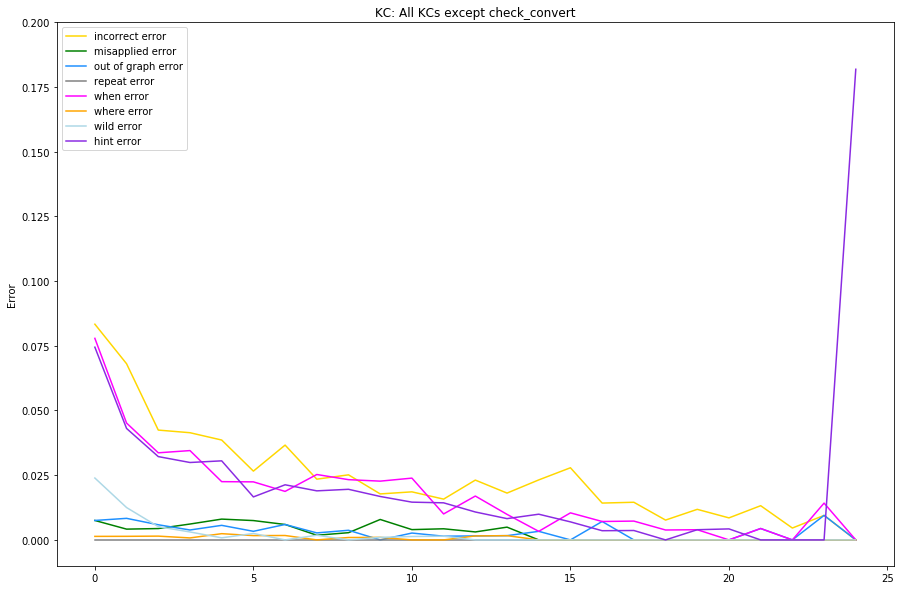

In [28]:
# humans
student_path = "human_err_split.txt"
selection = ['AD den3', 'AD den5', 'AD den4', 'AS done', 'AD num3', 'M done', 'AD num4', 'AD num5', 'M num5', 'AS num5', 'M den5', 'AS den5', 'AD done']
#plot_learning_curves(student_path, "All KCs -- human", KC = 'KC (Field)', shrink= True)

plot_learning_curves(student_path, "All KCs except check_convert", selection = selection, shrink = True)
#plot_learning_curves(student_path, "All KCs -- human", KC = 'KC (Field)')

['AD den3', 'AD den5', 'AD den4', 'AS done', 'AD num3', 'M done', 'AD num4', 'AD num5', 'M num5', 'AS num5', 'M den5', 'AS den5', 'AD done']


<Figure size 432x288 with 0 Axes>

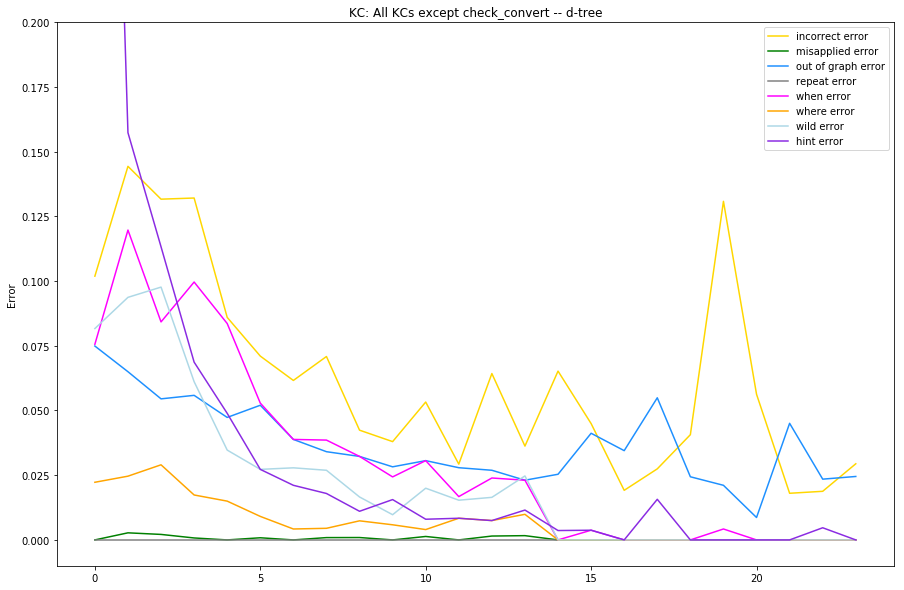

In [29]:
#decision tree
d_path = "/home/danny/Projects/error_analysis/decision_tree_err_split_conv.txt"
plot_learning_curves(d_path, "All KCs except check_convert -- d-tree", selection=selection, shrink=True)

['AD den3', 'AD den5', 'AD den4', 'AS done', 'AD num3', 'M done', 'AD num4', 'AD num5', 'M num5', 'AS num5', 'M den5', 'AS den5', 'AD done']


<Figure size 432x288 with 0 Axes>

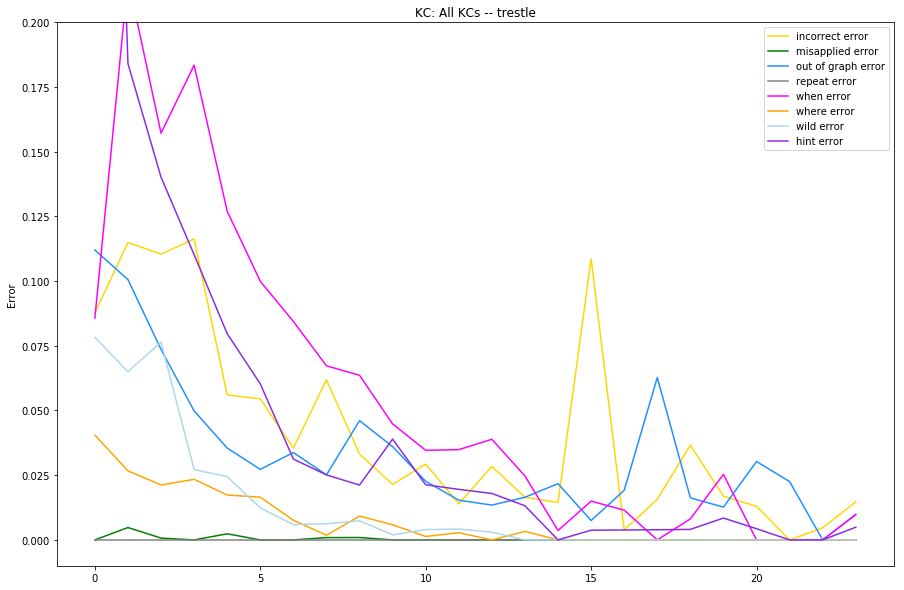

In [30]:
#trestle
t_path = "/home/danny/Projects/error_analysis/trestle_err_split_conv.txt"
plot_learning_curves(t_path, "All KCs -- trestle", selection=selection , shrink=True)

In [27]:
# iso
iso_path = "/Users/daniellaye/Desktop/iso_sai/match_sai_iso.csv"
plot_learning_curves(iso_path, "All KCs -- iso")

# control
control_path = "/Users/daniellaye/Desktop/control_sai/match_sai_control.csv"
plot_learning_curves(control_path, "All KCs -- control")

IOError: File /Users/daniellaye/Desktop/iso_sai/match_sai_iso.csv does not exist

In [ ]:
# students grouped by intercepts

s1_path, s2_path, s3_path = "/Users/daniellaye/Desktop/cluster_human/stu1.csv", "/Users/daniellaye/Desktop/cluster_human/stu2.csv", "/Users/daniellaye/Desktop/cluster_human/stu3.csv"

plot_learning_curves(s1_path, "All KCs -- s1 (low intercepts)")
plot_learning_curves(s2_path, "All KCs -- s2 (medium intercepts)")
plot_learning_curves(s3_path, "All KCs -- s3 (high intercepts)")





<br/><br/><br/><br/><br/><br/> 
### Plotting learning curves across clusters
> To plot a graph showing errors across three clusters aggregated across all KCs with respect to number of opportunities, use 
**error_by_clusters(*title*, *c1_path*, *c2_path*, *c3_path*, *error = 'Errors'*)** 
<br/><br/>
> Parameters: 
- title - title of the graph
- c1_path - a path for the transaction log of first cluster 
- c2_path - a path for the transaction log of second cluster 
- c3_path - a path for the transaction log of third cluster 
- error - types of errors to compare acdross clusters

> Example in cells below: 

In [ ]:
# errors across clusters 
error_by_clusters("total errors by cluster", s1_path, s2_path, s3_path, error = 'Errors')
error_by_clusters("hint errors by cluster", s1_path, s2_path, s3_path, error = 'Hint Errors')

<br/><br/><br/><br/><br/><br/> 
### Plotting residuals of iso and student errors
> To plot a graph showing the residuals of iso and student curves (student curves - iso curves), use 
**residuals_kc(*name*, *stu_path*, *iso_path*)** 
<br/><br/>
> Parameters: 
- name: title of the graph
- stu_path: path for the student transaction log
- iso_path: path for the iso transaction log

> Example in cell below:     
    
    

In [ ]:
residuals_kc("residuals (student curves - iso curves)", student_path, iso_path)